In [3]:
# Importing modules
from os import listdir, system
import pandas as pd
import numpy as np
import sys
import time
import pandas as pd

import cv2 as cv2
import imutils
import imageio
import pickle
from IPython.display import clear_output, display, HTML


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from skimage.io import imread
from skimage import measure
from skimage.measure import regionprops
from skimage.transform import resize
from scipy import ndimage


# Downloading dataset from: http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
# You can comment this after running once.

# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
# !tar -xvzf ./EnglishImg.tgz && rm -rf EnglishImg.tgz
# !git clone https://github.com/captcha-breakers/dataset-simple-uppercase.git

In [4]:
# Setting up folders
base_dir = "./English/Img/GoodImg/Bmp/"
folders = listdir(base_dir)
folders.sort()
folders = folders[10:36]
print(folders)

# Setting image_size
image_size = (24, 24)

['Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036']


In [14]:
# Collecting images from folders
data = []
total_images = 0
for i in folders:
    all_images = listdir(base_dir+i)[:150]
    total_images+=len(all_images)
    currentlabel = int(i[6:])-11

    for name in all_images:
        image = cv2.imread(base_dir+i+"/"+name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, image_size)

        # Filtering
        image = cv2.GaussianBlur(image,(5,5),0)
        image = cv2.Laplacian(image,cv2.CV_64F)
        image = cv2.GaussianBlur(image,(5,5),0)
        kernel = np.ones((3, 3), np.uint8)
        image = cv2.filter2D(image,-1,kernel)
        
        data.append((image/255, currentlabel))
    
    print("Images for", chr(65-11+int(i[6:])),":",  len(all_images))
print("Total images: ", total_images)

Images for A : 150
Images for B : 115
Images for C : 150
Images for D : 150
Images for E : 150
Images for F : 79
Images for G : 143
Images for H : 150
Images for I : 150
Images for J : 77
Images for K : 92
Images for L : 150
Images for M : 149
Images for N : 150
Images for O : 150
Images for P : 150
Images for Q : 35
Images for R : 150
Images for S : 150
Images for T : 150
Images for U : 92
Images for V : 84
Images for W : 67
Images for X : 80
Images for Y : 67
Images for Z : 55
Total images:  3085


In [18]:
# Shuffling data & making train/test
np.random.shuffle(data)
n = len(data)
p = int(80*n/100)

train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(n):
    if i<p:
        train_images.append(data[i][0])
        train_labels.append(data[i][1])
    else:
        test_images.append(data[i][0])
        test_labels.append(data[i][1])

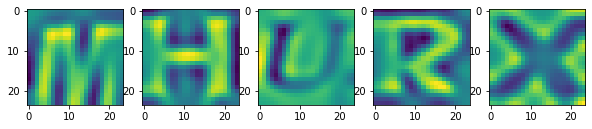

In [33]:
# Visualizing Training data
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 5, 1)
imshow(data[0][0])
fig.add_subplot(1, 5, 2)
imshow(data[1][0])
fig.add_subplot(1, 5, 3)
imshow(data[2][0])
fig.add_subplot(1, 5, 4)
imshow(data[3][0])
fig.add_subplot(1, 5, 5)
imshow(data[4][0])
plt.show()

In [36]:
# Making the model and training it
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=image_size),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(26)
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.fit(np.array(train_images), np.array(train_labels), epochs=20, batch_size=100)

Epoch 1/20
25/25 [==============================] - 0s 2ms/step - loss: 3.1299 - accuracy: 0.1160
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 2.3422 - accuracy: 0.3871
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 1.5287 - accuracy: 0.6219
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 1.0529 - accuracy: 0.7270
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.7947 - accuracy: 0.7953
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5809 - accuracy: 0.8475
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8993
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3273 - accuracy: 0.9325
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2609 - accuracy: 0.9497
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2018 - accuracy: 0.9698
Epoch 11/20
25/25 [

In [37]:
# Predicting on test images
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(np.array(test_images))

p=0
for i in range(len(test_images)):
  if np.argmax(predictions[i]) == test_labels[i]:
    p+=1

print("Test accuracy: ", 100*p/len(test_images))
# system("mkdir -p models")
# model.save('./models/my_model_84.h5')

Test accuracy:  77.47163695299838


In [15]:
# Segmenting captcha & predicting using CNN model
fil_dir = "./dataset-simple-uppercase/data/"
total = 0
char_p = 0
char_n = 0
cap_p = 0
cap_n = 0

for fil in listdir(fil_dir):
  image = cv2.imread(fil_dir + fil)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

  cnts, new = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
  captcha = np.invert(thresh)
  labelled_captcha = measure.label(captcha)

  character_dimensions = (0.20*captcha.shape[0], 0.8*captcha.shape[0], 0.03*captcha.shape[1], 0.25*captcha.shape[1])
  min_height, max_height, min_width, max_width = character_dimensions

  characters = []
  charactersx = []
  counter=0
  column_list = []
  row_list = []
  d = []
  for regions in regionprops(labelled_captcha):
      y0, x0, y1, x1 = regions.bbox
      region_height = y1 - y0
      region_width = x1 - x0

      if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
          roi = captcha[y0:y1, x0:x1]
          resized_char = cv2.copyMakeBorder(roi, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
          resized_char = resize(roi, image_size)
          column_list.append(x0)
          d.append([x0, resized_char])
  
  sorted(d)
  predicted_captcha = ""  
  ind=0
  for _,each_character in d:
      x_p,y_p = 3,3
      each_character = cv2.copyMakeBorder(each_character, x_p, x_p, y_p, y_p, cv2.BORDER_CONSTANT)
      each_character = cv2.resize(each_character,image_size)
#       imshow(each_character), plt.show()
      each_character = each_character.reshape(1, -1)
    
      result, = probability_model.predict([each_character])
      if fil[ind] == chr(65+np.argmax(result)):char_p += 1
      else:char_n += 1
      
      predicted_captcha+=chr(65+np.argmax(result))
      ind += 1
  total+=1
  
  if fil[:6] == predicted_captcha: cap_p+=1
  else: cap_n+=1
  
  # Printing statistics
  stats = pd.DataFrame(
    [
        [char_p, char_n, 100*char_p/(char_p+char_n)], 
        [cap_p, cap_n, 100*cap_p/(cap_p+cap_n)]
    ], 
    index=["Char", "Captcha"],
    columns=["Pos", "Neg", "Acc"]
  )
    
  clear_output(wait=True)
  display(HTML(stats.to_html()))
  print("Current file: ", total)
  print(fil[:6], ":", predicted_captcha)

,Pos,Neg,Acc
Char,43548,13407,76.460363
Captcha,3152,6848,31.520000


Current file:  10000
FXYQIR : PXYQR
